<a href="https://colab.research.google.com/github/Chikati2001/bayesian-network-for-car-diagnostics/blob/main/ML_project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [123]:
!apt -qq install libgraphviz-dev
!apt-get -qq install -y graphviz && pip install pygraphviz
import networkx as nx
import matplotlib.pyplot as plt

The following additional packages will be installed:
  libatk1.0-0 libatk1.0-data libgail-common libgail18 libgtk2.0-0
  libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk librsvg2-common
  libxcomposite1 libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libatk1.0-0 libatk1.0-data libgail-common libgail18 libgraphviz-dev
  libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxcomposite1 libxdot4
0 upgraded, 12 newly installed, 0 to remove and 1 not upgraded.
Need to get 2,496 kB of archives.
After this operation, 7,963 kB of additional disk space will be used.
Selecting previously unselected package libatk1.0-data.
(Reading database ... 117528 files and directories currently installed.)
Preparing to unpack .../00-libatk1.0-data_2.36.0-3build1_all.deb ...
Unpacking libatk1.0-data (2.36.0-3build1) ...
Selecting previously unselected package libatk1.0-0:amd64.
Preparing to unpack .../01-libatk1.0-0_2.36.0-3build1_amd64.deb .

In [124]:
def setup_graph_layout(G):
    # LEvel - 0
    G.add_node("ba", ba_y=0.2, ba_n=0.8)
    G.add_node("ab", ab_y=0.1, ab_n=0.9)
    G.add_node("fb", fb_y=0.3, fb_n=0.7)
    # Level - 1
    G.add_node("bd", ba_y_bd_y= 0.7, ba_n_bd_y = 0.2, ba_y_bd_n = 0.3, ba_n_bd_n = 0.8)
    G.add_node("nc", ab_y_fb_y_nc_y= 0.75, ab_y_fb_n_nc_y= 0.4, ab_n_fb_y_nc_y= 0.6, ab_n_fb_n_nc_y= 0.1,ab_y_fb_y_nc_n= 0.25, ab_y_fb_n_nc_n= 0.6, ab_n_fb_y_nc_n= 0.4, ab_n_fb_n_nc_n= 0.9)
    # Level 0-1 Edges
    G.add_edges_from([("ba", "bd")])
    G.add_edges_from([("ab", "nc"), ("fb", "nc")])

    # LEvel - 2
    G.add_node("bf", bd_y_nc_y_bf_y= 0.95, bd_y_nc_n_bf_y= 0.85, bd_n_nc_y_bf_y= 0.8, bd_n_nc_n_bf_y= 0.1,bd_y_nc_y_bf_n= 0.05, bd_y_nc_n_bf_n= 0.15, bd_n_nc_y_bf_n= 0.2, bd_n_nc_n_bf_n= 0.9)
    G.add_node("no", no_y = 0.05, no_n = 0.95)
    # Level 1-2 Edges
    G.add_edges_from([("bd", "bf"), ("nc", "bf")])

    # Level - 3
    G.add_node("l", bf_y_l_y= 0.05, bf_n_l_y = 0.9, bf_y_l_n = 0.95, bf_n_l_n = 0.1)
    G.add_node("gg", bf_y_gg_y= 0.1, bf_n_gg_y = 0.95, bf_y_gg_n = 0.9, bf_n_gg_n = 0.05)
    G.add_node("dl", no_y_dl_y= 0.95, no_n_dl_y = 0.3, no_y_dl_n = 0.05, no_n_dl_n = 0.7)
    # Level 2-3 Edges
    G.add_edges_from([("bf", "l"), ("bf", "gg")])
    G.add_edges_from([("no", "dl")])

    # print(G.nodes, G.edges)

    return G

def show_graph(G):
    links = [(u, v) for (u, v, d) in G.edges(data=True)]
    pos = nx.nx_agraph.graphviz_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue', linewidths=0.25) # draw nodes
    nx.draw_networkx_edges(G, pos, edgelist=links, width=4)                               # draw edges
    nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif")
    plt.title('Bayesian Network - Car Diagnosis ')
    plt.show()

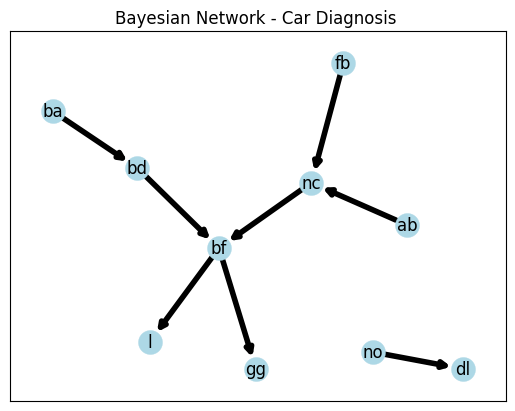

In [125]:
G = nx.DiGraph()
G = setup_graph_layout(G)
show_graph(G)

In [126]:
def get_signed_parents(G, node, signed_vars):
    node_name = node.split("_")[0]
    parents = list(G.predecessors(node_name)) # Get parents of a node
    signed_parents = []
    for parent in parents:
        for var in signed_vars:
            if parent in var: signed_parents.append(var)
    return node_name, signed_parents

In [127]:
# Reccursive Function that keeps calling till all free variables are signed.
def calculate_prob(G, signed_vars, free_vars):
    if not free_vars:
        # Calculating prob since all are signed.
        prob = 1.0
        for var in signed_vars:
            node_name, parents = get_signed_parents(G, var, signed_vars)
            prob_att = "_".join(parents + [var])
            prob_var = G.nodes[node_name].get(prob_att)
            prob *= prob_var
        print("Prob{} = {:.6f}".format(signed_vars, prob))
        return prob

    # make free_var as "y"
    prob_y = calculate_prob(G, signed_vars + [f"{free_vars[-1]}_y"], free_vars[:-1])
    # make free_Var as "n"
    prob_n = calculate_prob(G, signed_vars + [f"{free_vars[-1]}_n"], free_vars[:-1])

    return prob_y + prob_n

In [128]:
r2_prob = calculate_prob(G, signed_vars = ["fb_y", "l_n", "gg_n"], free_vars = ["nc", "ab", "bf", "bd", "ba"])
print("----------------------------------------------")
print("Total Probability for R2: {:.4f}".format(r2_prob))

Prob['fb_y', 'l_n', 'gg_n', 'ba_y', 'bd_y', 'bf_y', 'ab_y', 'nc_y'] = 0.002559
Prob['fb_y', 'l_n', 'gg_n', 'ba_y', 'bd_y', 'bf_y', 'ab_y', 'nc_n'] = 0.000763
Prob['fb_y', 'l_n', 'gg_n', 'ba_y', 'bd_y', 'bf_y', 'ab_n', 'nc_y'] = 0.018422
Prob['fb_y', 'l_n', 'gg_n', 'ba_y', 'bd_y', 'bf_y', 'ab_n', 'nc_n'] = 0.010988
Prob['fb_y', 'l_n', 'gg_n', 'ba_y', 'bd_y', 'bf_n', 'ab_y', 'nc_y'] = 0.000001
Prob['fb_y', 'l_n', 'gg_n', 'ba_y', 'bd_y', 'bf_n', 'ab_y', 'nc_n'] = 0.000001
Prob['fb_y', 'l_n', 'gg_n', 'ba_y', 'bd_y', 'bf_n', 'ab_n', 'nc_y'] = 0.000006
Prob['fb_y', 'l_n', 'gg_n', 'ba_y', 'bd_y', 'bf_n', 'ab_n', 'nc_n'] = 0.000011
Prob['fb_y', 'l_n', 'gg_n', 'ba_y', 'bd_n', 'bf_y', 'ab_y', 'nc_y'] = 0.000923
Prob['fb_y', 'l_n', 'gg_n', 'ba_y', 'bd_n', 'bf_y', 'ab_y', 'nc_n'] = 0.000038
Prob['fb_y', 'l_n', 'gg_n', 'ba_y', 'bd_n', 'bf_y', 'ab_n', 'nc_y'] = 0.006648
Prob['fb_y', 'l_n', 'gg_n', 'ba_y', 'bd_n', 'bf_y', 'ab_n', 'nc_n'] = 0.000554
Prob['fb_y', 'l_n', 'gg_n', 'ba_y', 'bd_n', 'bf_n', 

In [129]:
r3_prob = calculate_prob(G, signed_vars = ["ab_y", "l_n", "gg_n"], free_vars = ["nc", "fb", "bf", "bd", "ba"])
print("----------------------------------------------")
print("Total Probability for R3: {:.4f}".format(r3_prob))

Prob['ab_y', 'l_n', 'gg_n', 'ba_y', 'bd_y', 'bf_y', 'fb_y', 'nc_y'] = 0.002559
Prob['ab_y', 'l_n', 'gg_n', 'ba_y', 'bd_y', 'bf_y', 'fb_y', 'nc_n'] = 0.000763
Prob['ab_y', 'l_n', 'gg_n', 'ba_y', 'bd_y', 'bf_y', 'fb_n', 'nc_y'] = 0.003184
Prob['ab_y', 'l_n', 'gg_n', 'ba_y', 'bd_y', 'bf_y', 'fb_n', 'nc_n'] = 0.004273
Prob['ab_y', 'l_n', 'gg_n', 'ba_y', 'bd_y', 'bf_n', 'fb_y', 'nc_y'] = 0.000001
Prob['ab_y', 'l_n', 'gg_n', 'ba_y', 'bd_y', 'bf_n', 'fb_y', 'nc_n'] = 0.000001
Prob['ab_y', 'l_n', 'gg_n', 'ba_y', 'bd_y', 'bf_n', 'fb_n', 'nc_y'] = 0.000001
Prob['ab_y', 'l_n', 'gg_n', 'ba_y', 'bd_y', 'bf_n', 'fb_n', 'nc_n'] = 0.000004
Prob['ab_y', 'l_n', 'gg_n', 'ba_y', 'bd_n', 'bf_y', 'fb_y', 'nc_y'] = 0.000923
Prob['ab_y', 'l_n', 'gg_n', 'ba_y', 'bd_n', 'bf_y', 'fb_y', 'nc_n'] = 0.000038
Prob['ab_y', 'l_n', 'gg_n', 'ba_y', 'bd_n', 'bf_y', 'fb_n', 'nc_y'] = 0.001149
Prob['ab_y', 'l_n', 'gg_n', 'ba_y', 'bd_n', 'bf_y', 'fb_n', 'nc_n'] = 0.000215
Prob['ab_y', 'l_n', 'gg_n', 'ba_y', 'bd_n', 'bf_n', 

In [130]:
r4_prob = calculate_prob(G, signed_vars = ["gg_n", "ba_y", "ab_n", "fb_n"], free_vars = ["nc", "bd", "bf"])
print("----------------------------------------------")
print("Total Probability for R4: {:.4f}".format(r4_prob))

Prob['gg_n', 'ba_y', 'ab_n', 'fb_n', 'bf_y', 'bd_y', 'nc_y'] = 0.007541
Prob['gg_n', 'ba_y', 'ab_n', 'fb_n', 'bf_y', 'bd_y', 'nc_n'] = 0.060726
Prob['gg_n', 'ba_y', 'ab_n', 'fb_n', 'bf_y', 'bd_n', 'nc_y'] = 0.002722
Prob['gg_n', 'ba_y', 'ab_n', 'fb_n', 'bf_y', 'bd_n', 'nc_n'] = 0.003062
Prob['gg_n', 'ba_y', 'ab_n', 'fb_n', 'bf_n', 'bd_y', 'nc_y'] = 0.000022
Prob['gg_n', 'ba_y', 'ab_n', 'fb_n', 'bf_n', 'bd_y', 'nc_n'] = 0.000595
Prob['gg_n', 'ba_y', 'ab_n', 'fb_n', 'bf_n', 'bd_n', 'nc_y'] = 0.000038
Prob['gg_n', 'ba_y', 'ab_n', 'fb_n', 'bf_n', 'bd_n', 'nc_n'] = 0.001531
----------------------------------------------
Total Probability for R4: 0.0762


# R1

In [79]:
import networkx as nx
import matplotlib.pyplot as plt


G = nx.DiGraph()

nodes = {
    "ba": {"ba_y": 0.2, "ba_n": 0.8},
    "ab": {"ab_y": 0.1, "ab_n": 0.9},
    "fb": {"fb_y": 0.3, "fb_n": 0.7},
    "bd": {"ba_y_bd_y": 0.7, "ba_n_bd_y": 0.2, "ba_y_bd_n": 0.3, "ba_n_bd_n": 0.8},
    "nc": {"ab_y_fb_y_nc_y": 0.75, "ab_y_fb_n_nc_y": 0.4, "ab_n_fb_y_nc_y": 0.6, "ab_n_fb_n_nc_y": 0.1,
           "ab_y_fb_y_nc_n": 0.25, "ab_y_fb_n_nc_n": 0.6, "ab_n_fb_y_nc_n": 0.4, "ab_n_fb_n_nc_n": 0.9},
    "bf": {"bd_y_nc_y_bf_y": 0.95, "bd_y_nc_n_bf_y": 0.85, "bd_n_nc_y_bf_y": 0.8, "bd_n_nc_n_bf_y": 0.1,
           "bd_y_nc_y_bf_n": 0.05, "bd_y_nc_n_bf_n": 0.15, "bd_n_nc_y_bf_n": 0.2, "bd_n_nc_n_bf_n": 0.9},
    "no": {"no_y": 0.05, "no_n": 0.95},
    "l": {"bf_y_l_y": 0.05, "bf_n_l_y": 0.9, "bf_y_l_n": 0.95, "bf_n_l_n": 0.1},
    "gg": {"bf_y_gg_y": 0.1, "bf_n_gg_y": 0.95, "bf_y_gg_n": 0.9, "bf_n_gg_n": 0.05},
    "dl": {"no_y_dl_y": 0.95, "no_n_dl_y": 0.3, "no_y_dl_n": 0.05, "no_n_dl_n": 0.7}}

In [80]:
edges = [("ba", "bd"), ("ab", "nc"), ("fb", "nc"), ("bd", "bf"), ("nc", "bf"), ("bf", "l"), ("bf", "gg"), ("no", "dl")]
G.add_edges_from(edges)

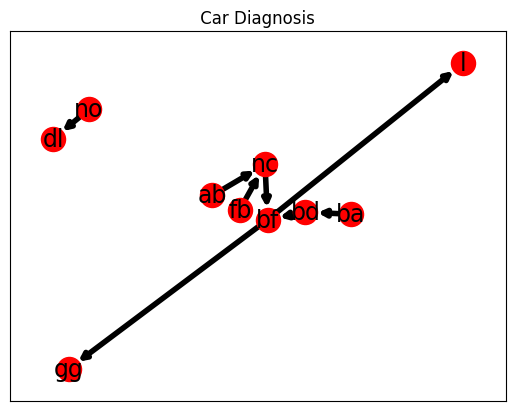

In [122]:
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos,node_color='r')
nx.draw_networkx_edges(G, pos, width=4)
nx.draw_networkx_labels(G, pos, font_size=17)
plt.title(' Car Diagnosis ')
plt.show()


# R2

In [82]:
P = 0
for ba_value in ["ba_y", "ba_n"]:
    for ab_value in ["ab_y", "ab_n"]:
        for bd_value in ["bd_y", "bd_n"]:
            for bf_value in ["bf_y", "bf_n"]:
                for nc_value in ["nc_y", "nc_n"]:
                    fb_value = "fb_y"
                    l_value = "l_n"
                    gg_value = "gg_n"
                    J_prob = (nodes["fb"][fb_value]* nodes["l"][bf_value + "_"+l_value]* nodes["gg"][bf_value + "_"+gg_value]*
                                         nodes["ba"][ba_value] * nodes["ab"][ab_value] * nodes["bd"][ba_value + "_" + bd_value] *
                                         nodes["bf"][bd_value + "_" + nc_value + "_" + bf_value] *
                                         nodes["nc"][ab_value + "_" + fb_value + "_" + nc_value])

                    P += J_prob

print("Probability P(+fb|-l,-gg) R2:", P)

Probability P(+fb|-l,-gg) R2: 0.16592400000000002


# R3

In [83]:
P = 0
for ba_value in ["ba_y", "ba_n"]:
    for fb_value in ["fb_y", "fb_n"]:
        for bd_value in ["bd_y", "bd_n"]:
            for bf_value in ["bf_y", "bf_n"]:
                for nc_value in ["nc_y", "nc_n"]:
                    ab_value = "ab_y"
                    l_value = "l_n"
                    gg_value = "gg_n"
                    J_prob = (nodes["ab"][ab_value] * nodes["ba"][ba_value] * nodes["fb"][fb_value] * nodes["bd"][ba_value + "_" + bd_value] *
                                         nodes["bf"][bd_value + "_" + nc_value + "_" + bf_value] *nodes["l"][bf_value + "_"+l_value] *
                                         nodes["gg"][bf_value + "_"+gg_value] * nodes["nc"][ab_value + "_" + fb_value + "_" + nc_value])
                    P += J_prob
print("Probability P(+ab|-l,-gg) R3:", P)


Probability P(+ab|-l,-gg) R3: 0.05044600000000001


# R4

In [84]:
P = 0
for bd_value in ["bd_y", "bd_n"]:
    for bf_value in ["bf_y", "bf_n"]:
        for nc_value in ["nc_y", "nc_n"]:
            for l_value in ["l_y", "l_n"]:
                ba_value = "ba_y"
                ab_value = "ab_n"
                fb_value = "fb_n"
                gg_value = "gg_n"
                J_prob = (nodes["ba"][ba_value] * nodes["ab"][ab_value] * nodes["fb"][fb_value] *nodes["bd"][ba_value + "_" + bd_value] *
                                     nodes["bf"][bd_value + "_" + nc_value + "_" + bf_value] * nodes["l"][bf_value + "_"+l_value] *
                                     nodes["gg"][bf_value + "_"+gg_value] *nodes["nc"][ab_value + "_" + fb_value + "_" + nc_value])
                P += J_prob

print("Probability P(-gg|+ba, -ab, -fb)R4:", P)


Probability P(-gg|+ba, -ab, -fb)R4: 0.07623629999999998


# R5

The probability for the fanbelt being broken P(+fb∣−l,−gg) = 0.165924 is higher  compared to the probability for the alternator being broken P(+ab∣−l,−gg) = 0.050446. By this we can say that there's a greater likelihood of the fanbelt being the cause of the issues with the lights and the gas gauge compared to the alternator.